# Project 2 Notebook

## Part 1 - Open for Business - Open Reading Frame Detector in Python [25% marks]

In [18]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from Bio import SeqIO
from IPython.display import IFrame
import os


"""
Openning Fasta file using BioPython
I am choosing to Use BioPython since it easily deals with different line wrapping formats. 

Given that our we are going to be looking for the longest open reading frame it is best if we
can convert everything into DNA and make sure that sequences are clean. I am choosing not to worry
non standard characters since our sequence only contains standard characters and they would not be
problem in finding the longest open reading frame. 
"""
banned_words = ["exon", "intron", "utr", "peptide"]  # Added to remove clutter if any exons, UTRs, or peptide sequences are in our fasta file.
# Function to read fasta file - Done so that it can process a fasta file with multiple sequences.
def parse_and_read_fasta_sequences(fasta_filename):
    SeqIO_parsed_fasta_sequences = SeqIO.parse(open(fasta_filename), "fasta")
    fasta_sequences_dict = {}  # Initialising Empty dictionary to store the sequences
    for fasta in SeqIO_parsed_fasta_sequences:  # Iterating through the fasta sequences
        if any(banned_word in fasta.description.lower() for banned_word in banned_words):
            continue  # Skip this sequence if a banned word is found 
        fasta_sequences_dict[fasta.id] = str(fasta.seq)  # Storing Sequences using ID - N.b. this risks overwriting if there is repition of IDs
    return fasta_sequences_dict

# Function which removes white space, converts DNA to RNA, and makes everything upper case.
def clean_sequences(fasta_sequences_dict):
    cleaned_fasta_sequences = {}  # Initialising Empty dictionary to store the sequences
    for key, value in fasta_sequences_dict.items():  # Breaking it down into key and value pairs
        cleaned_fasta_sequences[key] = value.replace(" ", "").replace("U", "T").upper()  # Cleaning the sequences
    return cleaned_fasta_sequences


# Defining an ORF class to store the information of the ORF
class ORF:
    def __init__(self, start, end, sequence, name):
        self.start = start
        self.end = end
        self.sequence = sequence
        self.name = name

    @property
    def length(self):
        return self.end - self.start

"""
The cleanest way to find the different ORFs is to iterate through until we find a start codon
and then look for stop codons in the same reading frame, starting from the back. Then select the longest one. This means
that we are only looking through the reading frames which contain a start codon. This reduces the
computational expense of the algorithm. 
"""
start_codon = "ATG"
stop_codons = ["TAA", "TAG", "TGA"]

def find_orfs(clean_fasta_sequences):
    orfs_by_name = {}
    for name, seq in clean_fasta_sequences.items():
        orfs_by_name[name] = []
        seq_len = len(seq)
        for frame in range(3):
            # Iterating through from beginning to the last codon of the sequence every 3 characters. This can definitely be optimised because at the moment the way it searches for a stop codon is v inefficient.
            next_stop = None
            # walk backwards in-frame
            # start at the last codon index in this frame, down to 'frame'
            for i in range(frame + 3 * ((seq_len - frame - 1) // 3), frame - 1, -3):
                codon = seq[i:i+3]  # storing the codons as we walk back
                if codon in stop_codons:  # checking if it's a stop codon
                    # record the first stop you see (nearest 3' of any start)
                    next_stop = i
                elif codon == start_codon and next_stop is not None:
                    # slice from this start to that stop+3
                    orf = ORF(
                        start=i,
                        end=next_stop+3,
                        sequence=seq[i:next_stop+3],
                        name=name
                    )
                    orfs_by_name[name].append(orf)
    return orfs_by_name

def find_longest_orfs(orfs):
    """
    Uses max() function and a lambda function to find the longest ORF. Defaults to None if no ORF are stored.
    """
    longest_orfs = {}
    for name, orfs in orfs.items():
        longest_orfs[name] = max(orfs, key=lambda orf: orf.length, default=None)
    return longest_orfs

def sense_to_antisense(orf):
    """
    Uses a dictionary to map the nucleotides and returns the complement of the sequence.
    """
    complement = {"A": "T", "T": "A", "C": "G", "G": "C"}
    return "".join(complement[base] for base in orf.sequence)

codon_table = {
    "TTT": "F", "TTC": "F", "TTA": "L", "TTG": "L",
    "TCT": "S", "TCC": "S", "TCA": "S", "TCG": "S",
    "TAT": "Y", "TAC": "Y", "TAA": "*", "TAG": "*",
    "TGT": "C", "TGC": "C", "TGA": "*", "TGG": "W",
    "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAT": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "ATT": "I", "ATC": "I", "ATA": "I", "ATG": "M",
    "ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAT": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGT": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V",
    "GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAT": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G"
}

def sense_to_protein(orf):
    dna_seq = orf.sequence
    protein_seq = ""
    # Iterate over the sequence in steps of 3
    for i in range(0, len(dna_seq) - 2, 3):
        codon = dna_seq[i:i+3]
        # Look up the amino acid; use "?" as a fallback if the codon is not found
        amino_acid = codon_table.get(codon, "?")
        protein_seq += amino_acid
    return protein_seq


# Main Analysis 
def DNA_analysis(fasta_filename):
    """
    Parse and Read Fasta File
    Available Files for Part 1: "Homo_sapiens_ENST00000380152_8_sequence.fa", and "part1_sequence.fasta"
    """
    fasta_sequences_dict = parse_and_read_fasta_sequences(fasta_filename)
    # Clean It
    cleaned_sequences = clean_sequences(fasta_sequences_dict)
    # Find ORFs
    orfs = find_orfs(cleaned_sequences)
    # Find Longest Start, End, Length, and Protein Sequence
    longest_orfs = find_longest_orfs(orfs)
    antisense_strands = {}
    protein_sequences = {}
    for name, longest_orf in longest_orfs.items():
        if longest_orf is None:
            print(f"No ORF found for {name}.\n")
            continue  # Skip this sequence if no ORF was found.
        # Sense to Antisense
        antisense_stand = sense_to_antisense(longest_orf)
        antisense_strands[name] = antisense_stand
        # Sense to Protein
        protein_sequence = sense_to_protein(longest_orf)
        protein_sequences[name] = protein_sequence
        # Print Results
        print(f"The Longest ORF for {name} is from {longest_orf.start}-{longest_orf.end} with a length of {longest_orf.length}.\nThe Sequence is: {longest_orf.sequence[:50]}...\nThe Antisense Stand is: {antisense_stand[:50]}...\nThe Protein Sequence is: {protein_sequence[:50]}...\n")
    # Return the Longest ORF, Antisense Stand, and Protein Sequence
    return longest_orfs, antisense_strands, protein_sequences

BRCA2_fasta_longest_ORFs, BRCA2_fasta_antisense_stands, BRCA2_fasta_protein_sequences = DNA_analysis("Part 1/Homo_sapiens_ENST00000380152_8_sequence.fa")
# Testing and Usage commented out:
# TNF_longest_ORFs, TNF_antisense_stands, TNF_protein_sequences = DNA_analysis("Homo_sapiens_TNF_sequence-4.fa")
# dino1_longest_ORFs, dino1_antisense_stands, dino1_protein_sequences = DNA_analysis("part2_Dinosaur_DNA.fasta")
# dino2_longest_ORFs, dino2_antisense_stands, dino2_protein_sequences = DNA_analysis("part2_Dino_DNA_v2.fasta")

The Longest ORF for ENST00000380152.8 is from 199-10456 with a length of 10257.
The Sequence is: ATGCCTATTGGATCCAAAGAGAGGCCAACATTTTTTGAAATTTTTAAGAC...
The Antisense Stand is: TACGGATAACCTAGGTTTCTCTCCGGTTGTAAAAAACTTTAAAAATTCTG...
The Protein Sequence is: MPIGSKERPTFFEIFKTRCNKADLGPISLNWFEELSSEAPPYNSEPAEES...

The Longest ORF for BRCA2-201 is from 0-10257 with a length of 10257.
The Sequence is: ATGCCTATTGGATCCAAAGAGAGGCCAACATTTTTTGAAATTTTTAAGAC...
The Antisense Stand is: TACGGATAACCTAGGTTTCTCTCCGGTTGTAAAAAACTTTAAAAATTCTG...
The Protein Sequence is: MPIGSKERPTFFEIFKTRCNKADLGPISLNWFEELSSEAPPYNSEPAEES...

The Longest ORF for 13 is from 21197-25751 with a length of 4554.
The Sequence is: ATGATTTCTAGAGGCAAAGAATCATACAAAATGTCAGACAAGCTCAAAGG...
The Antisense Stand is: TACTAAAGATCTCCGTTTCTTAGTATGTTTTACAGTCTGTTCGAGTTTCC...
The Protein Sequence is: MISRGKESYKMSDKLKGNNYESDVELTKNIPMEKNQDVCALNENYKNVEL...



# Part 2: Jurassic Informatics – Decoding ‘Dinosaur’ DNA [25% marks]

## Investigating Dinosaur DNA Sequence
### Sequence 1
I used blastp to search for similar amino acid sequences to the longest ORF of the dinosaur DNA sequence in the UniProt Swiss-Prot database (The manually annotated section of UniProtKB). My search came back with one result, alignment visualised in Jalview using the Clustal Omega algorithm below. 
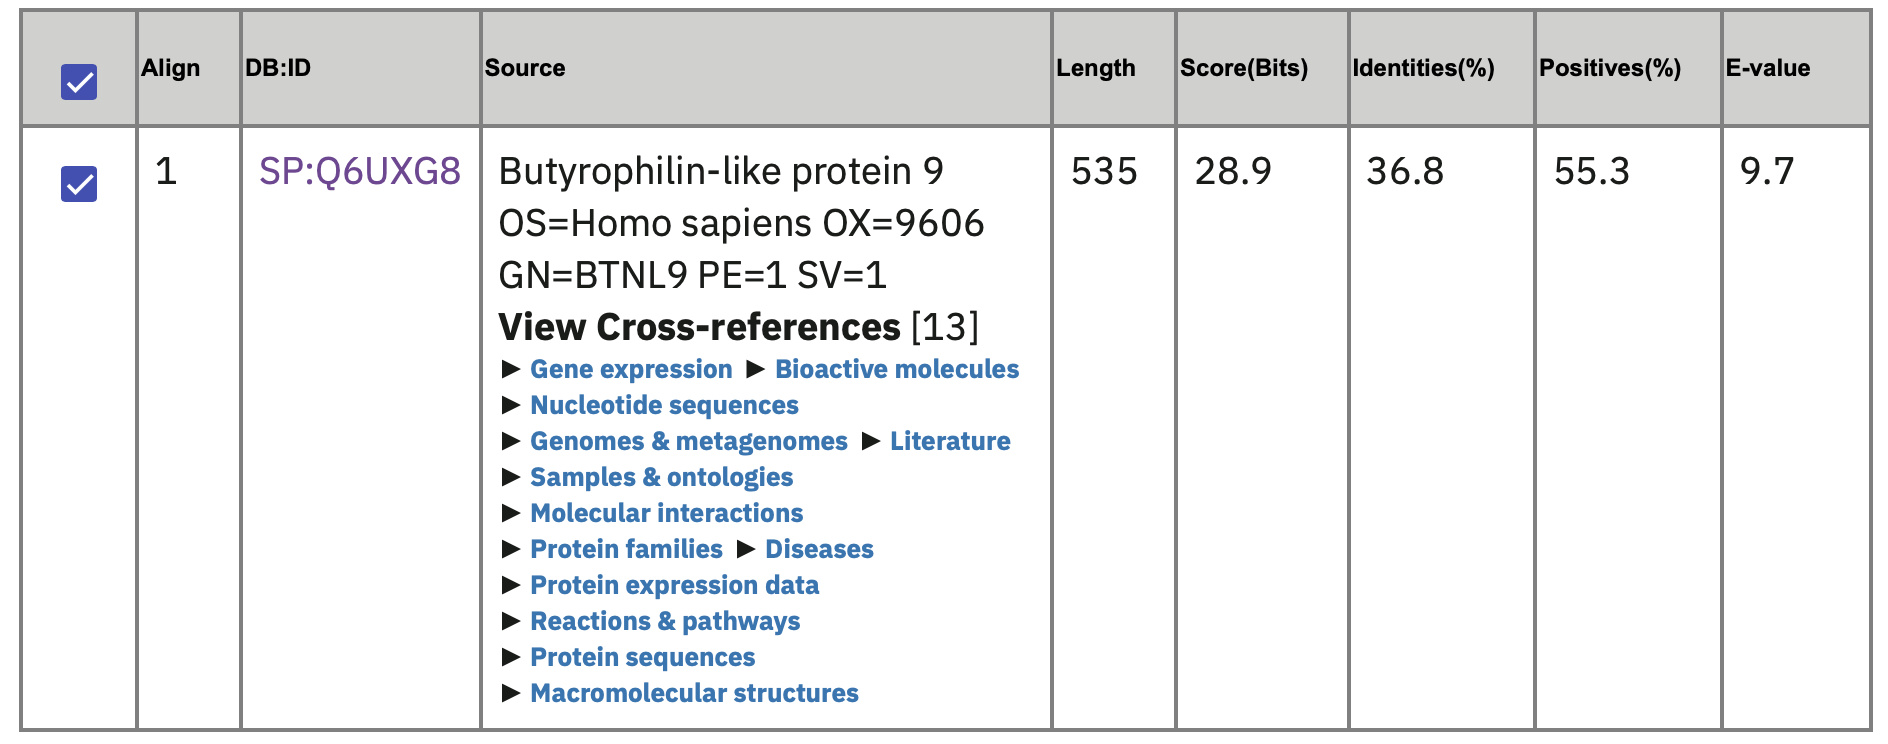
![JalView Alignment Visualisation.png](<attachment:JalView Alignment Visualisation.png>)

This singular match has a very high expectation (9.7) value suggests that this sequence has arisen from chance. This result would suggest that the sequence is ficticious and has no relation to any biological DNA sequence.

Following this, I used NCBI blastn to search for similar nucleotide sequences as the entirety of the given Dinosaur DNA sequence in the core_nt database. On first glance, this provided a host of possible options that the sequence could have dervied from. However, upon closer inspection of the taxonomy of the sequences the sequences all derive from NCBI "root" taxonomy, with the 97/100 of which being artificial sequences and the rest being from Pseudomonadota. To me, this suggests that these close matches are coincidental and should be disregarded as junk. This argument is solidified by the fact that many of the sequences where added to an update in the database in 2020 - thus long after Michael Crichton's writing of the book (Jurassic Park was first published in 1990). 

To be very thorough, I used blastp to search for similar amino acid sequences to the longest ORF of the dinosaur DNA sequence in the "All non-redundant protein database" (nrdb) is shown below:
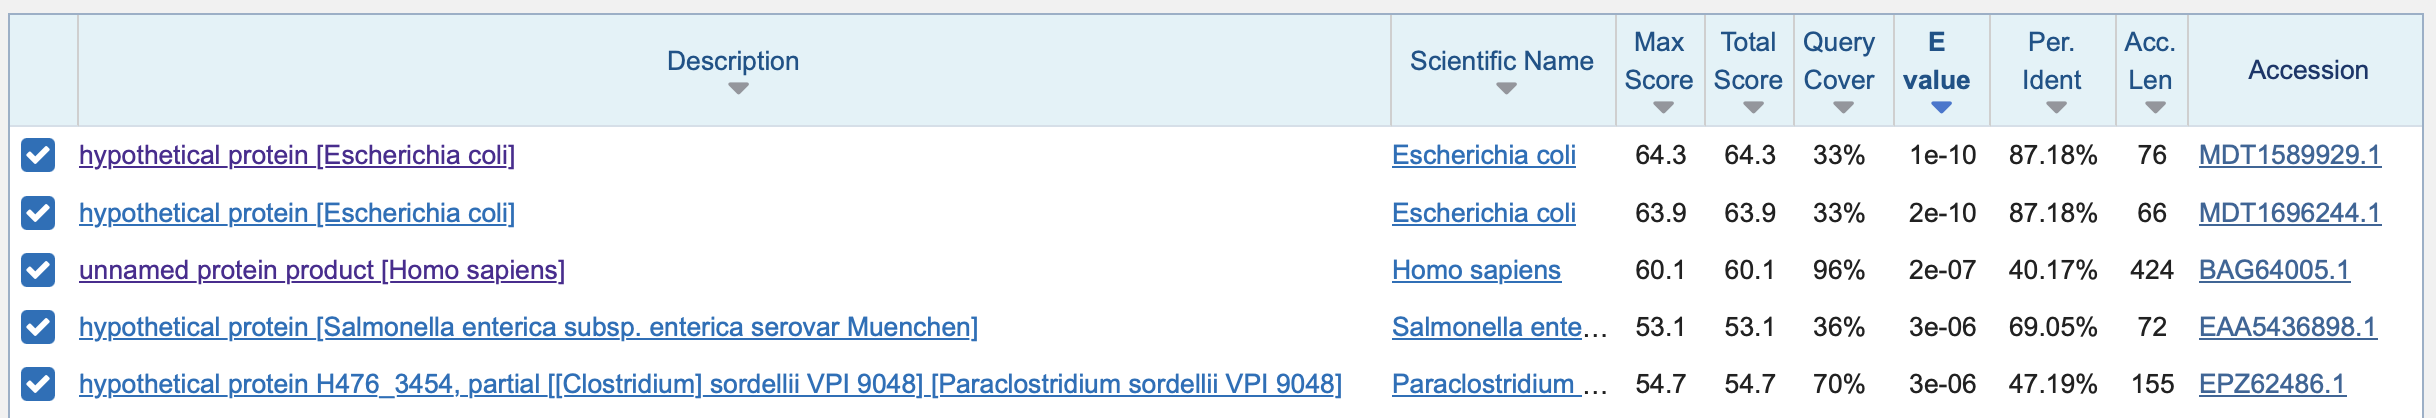
Breaking down the top five results:
We can immediately disregard the hypothetical proteins, as these are ficticious - this eliminates options 1,2,4,5. Option 3 is an unnamed human protein product with a high query cover (96%) but a low percentage identity (40.17%) suggesting that the there is a lengthy but badly matched alignment. If this sequence was in fact a real sequence, we would expect it to have excellent query cover and high percentage idenity. Additionally, this protein sequence was first published on the 24th of July 2008, once again after Jurassic Park was published and so this is definitely a coincidental match. This would suggest that the DNA sequence given in the book is entirely ficticious.

Thus, all of my results point towards the conclusion that this sequence is entirely ficticious and has no biological counterpart which it could've been derived from or associated with.

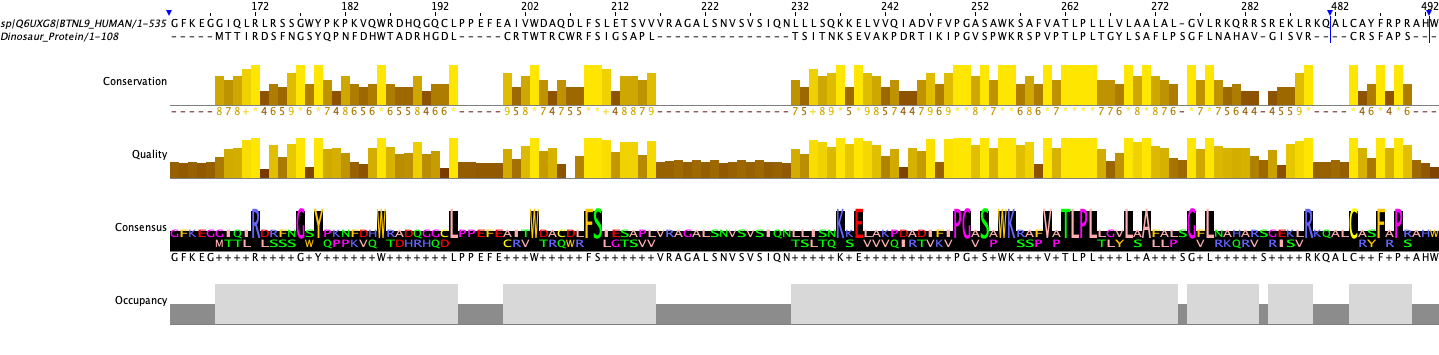

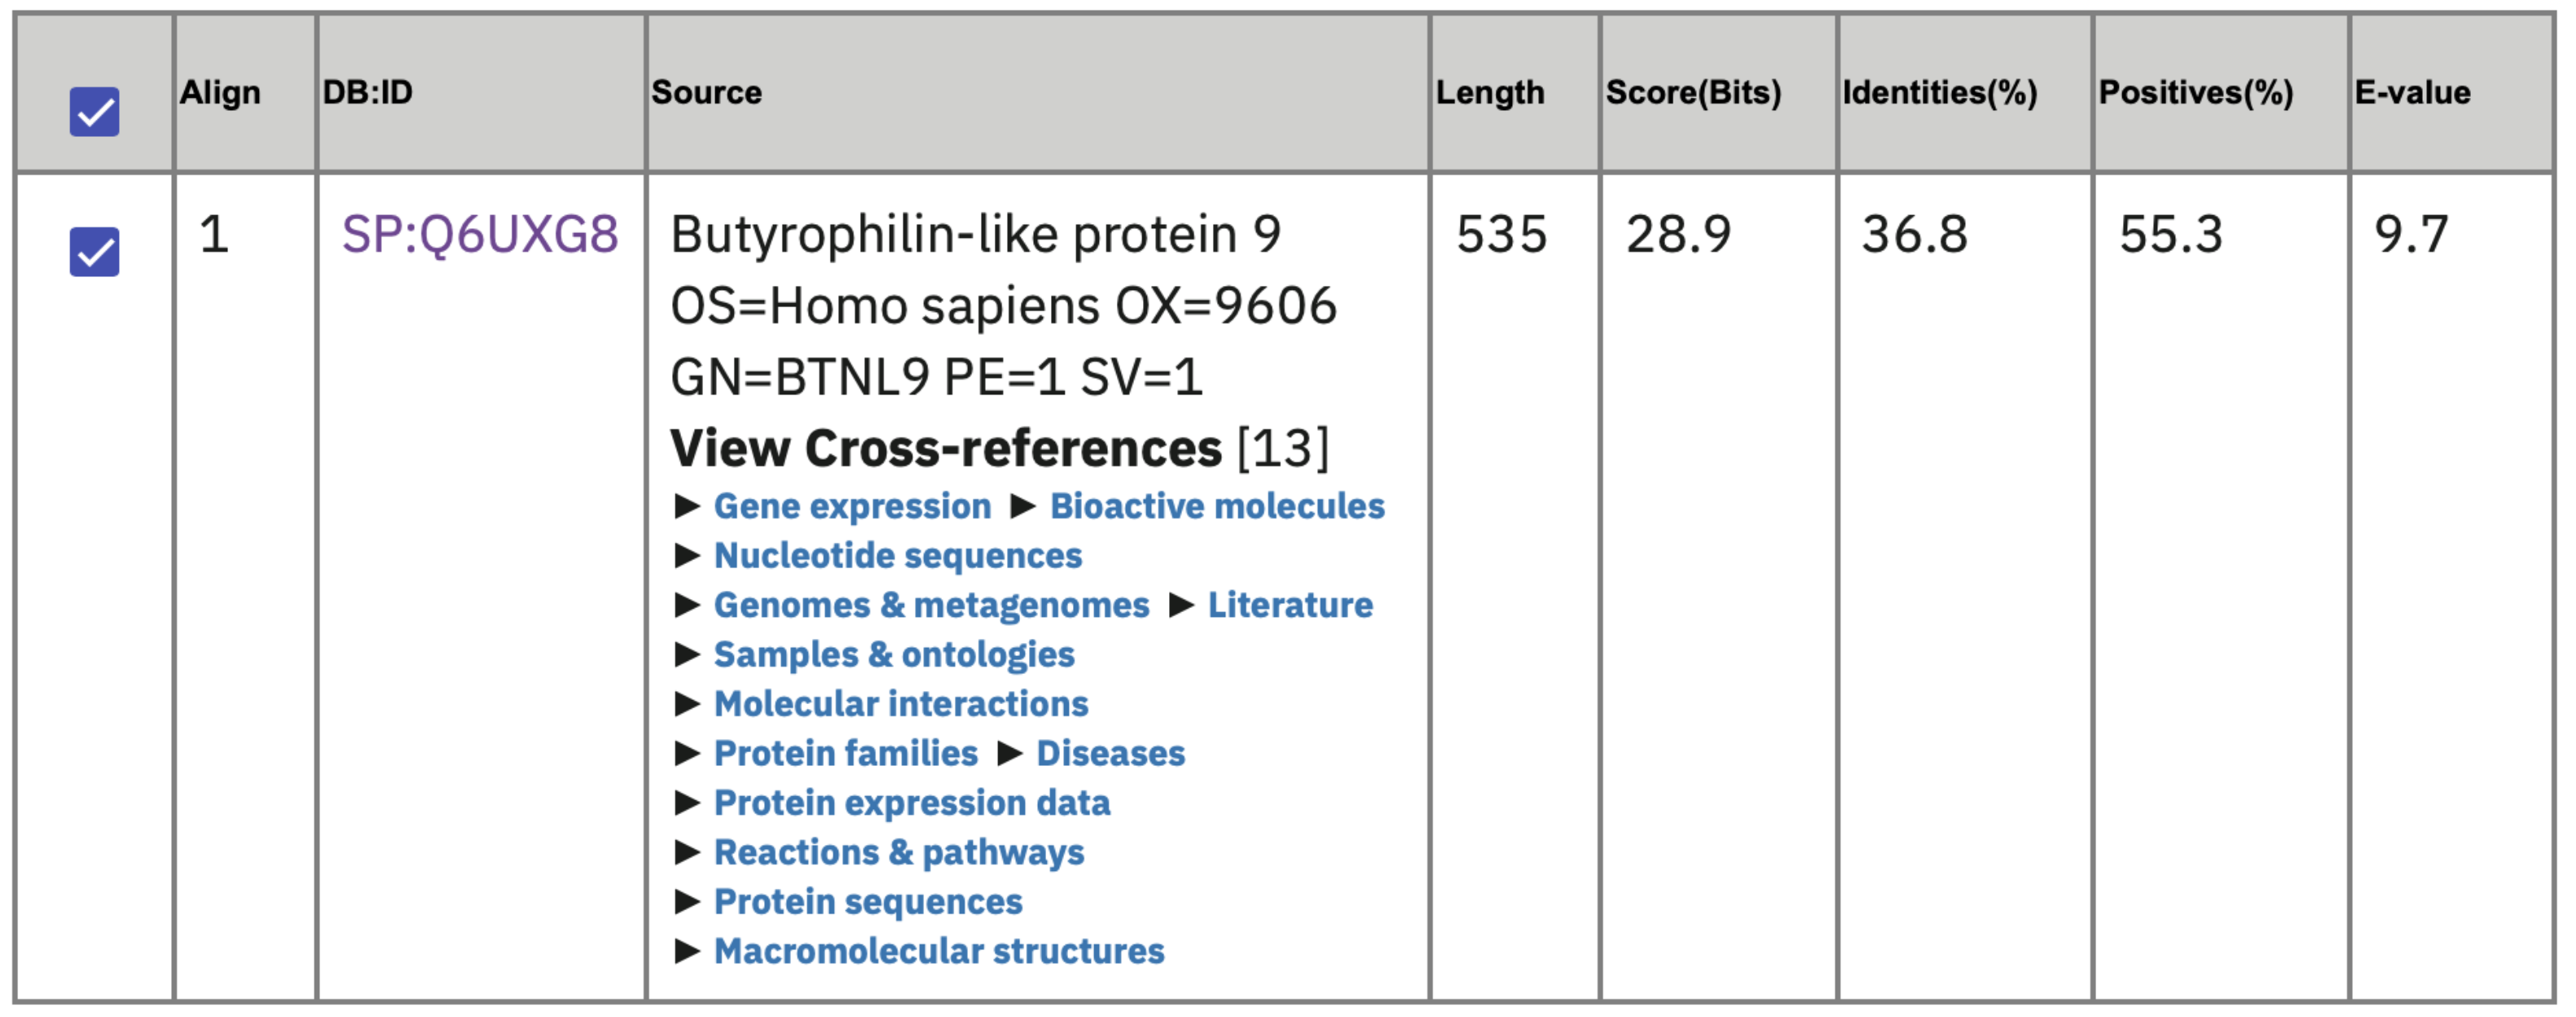

### Sequence 2
For the sequence found in "The Lost World" by Michael Crichton (1995), I underwent a similar process and found far more conclusive results.

I used blastp to search for similar amino acid sequences to the longest ORF of the dinosaur DNA sequence in the UniProt Swiss-Prot database. My search came back with a number of results but most importantly it came back with a result with an E-value of 0.  This suggests that this sequence is statistically indistinguishable from certainty. The jalview visualisation of the alignment created using Clustal Omega makes it easy to see why. What is interesting to note is that the sequence is not a carbon copy of the amino acid sequence from chickens. Mark Boguski appears to have inserted a number of amino acids throughout the protein coding sequence. Perhaps he did this to give it a chimeric look if anyone (like myself) chose to look deeper into it.
![Dino X Gallus Protein Alignment.png](<attachment:Dino X Gallus Protein Alignment.png>)
From all of this we can conclude that the longest ORF, and thus amino acid sequence, of the dinosaur DNA sequence certainly derived from this extract of chicken DNA.

This alignment is with a Gallus Gallus (Chicken) GATA 1 Binding Protein (Also known as an Erythroid transcription factor, UniProt Ref: P17678) first published in 1989. Chickens, and all modern bird for that matter, are strongly related to dinosaurs and both descend from a group of dinosaurs known as Theropods, these include Velociraptors and T. Rexes. Hence, one can imagine why Mark Boguski chose a sequence from chickens to be included in the book.

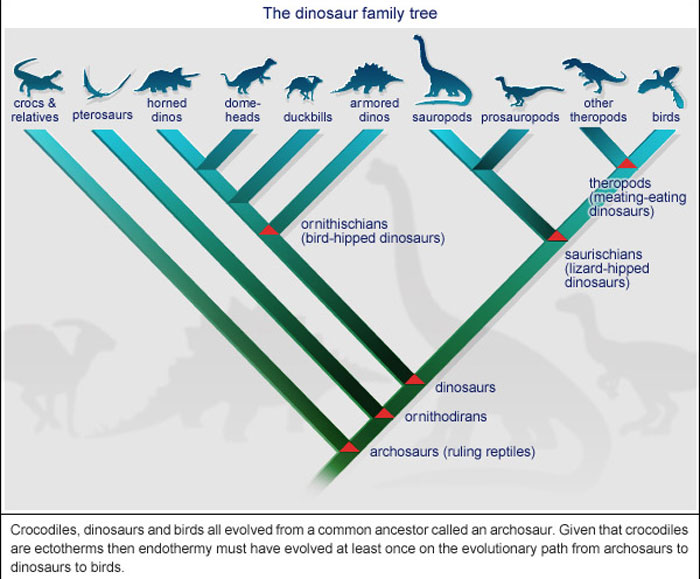
- [1] Figure 1. A diagram to demonstrate the relationship between dinosaurs and modern day birds. 

Furthermore, upon inspection of the entire DNA sequence we can gain a better appreciation for how this DNA sequence has been created. First, I noticed that there was next to no alignment between the 3' and 5' untranslated regions (UTRs) of the Dinosaur DNA sequence and the chicken DNA sequence. As a result of this, I used blastn to find sequences which were similar to the 3' and 5' UTRs and then used CLUSTAL in order to align all of the sequences together. Together, they provide a clear picture of how this sequence was created.
![Dino x Gallus x Xenopus without consensus.png](<attachment:Dino x Gallus x Xenopus without consensus.png>)

Here we can see that 3' UTR has been produced by stitching nucleotides 1-118 from the 3' UTR of the Xenopus laevis GATA binding protein 1 S homeolog gene (NM_001085775.1) to the beginning of the chicken translated region - creating a fictional 3' UTR for the sequence found in the book. Following this, nucleotides 1585-1938 of the X.laevis GATA-binding protein (XGATA-2) gene(M76564.1) has been stitched onto the end of the chicken translated region leading creating a 5' UTR. This leads to a sequence with a 3' UTR from Xenopus laevis (Frog), a translated region from Chicken, and a 5' UTR from a different, but related, frog gene. All in all, this creates a chimeric GATA binding protein gene composed of frog and chicken genes. 



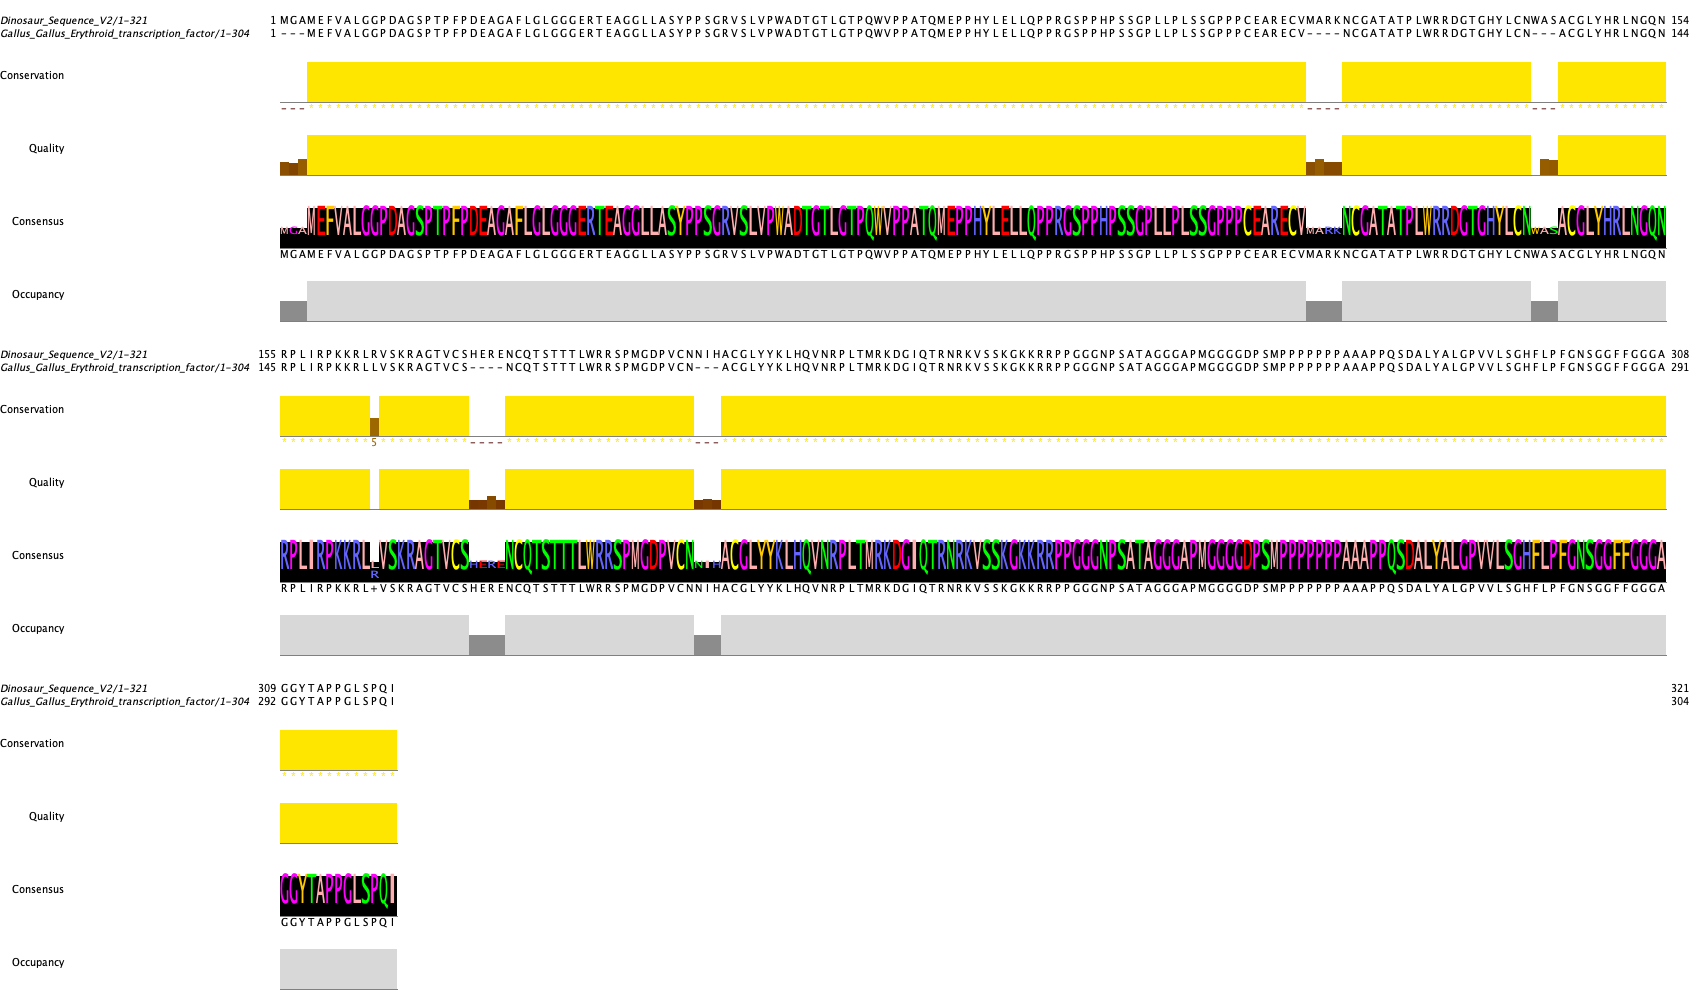
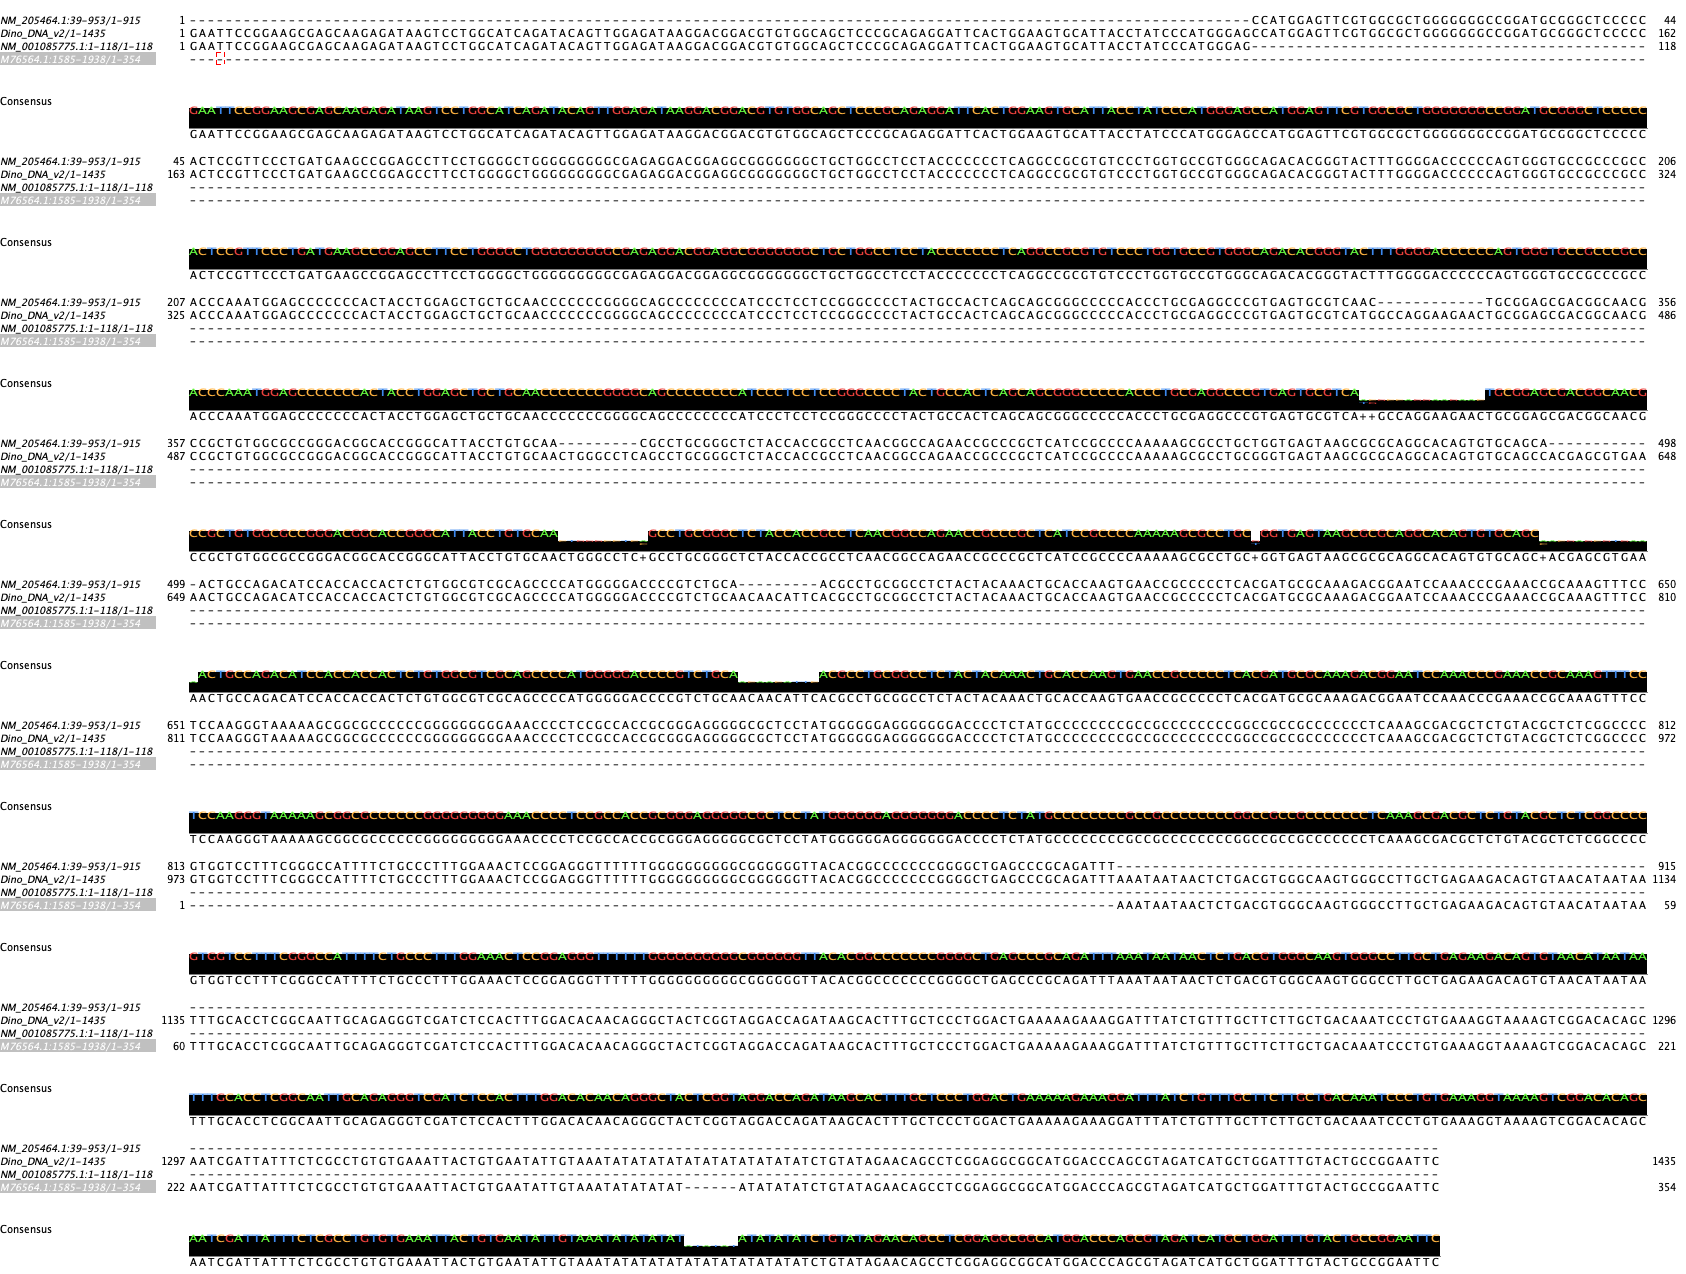

# Part 3
## Code Runthrough
The purpose of parse_blast_hits is to go through our blastp hits and filter those which meet our criteria:
    - E value <= 1e-30
    - A positive identity match of > 60% 
    - Alignment length of > 290
I chose to use % postive since this metric is calculated based on how similar the amino acids are in function and form rather than if they are an exact match (as is the case with % identity). This means that % positive gives us a more wholesome idea of whether the function of an amino acid is conserved. For our uses, this is what we want as we are looking for other olfactory receptor proteins (those with the same **function** as our query protein). This filtering reduced the number of protein IDs down to 463 sequences. 

The second function get_protein_sequences then takes these IDs and finds their sequences in the database so that these sequences can later be aligned using CLUSTAL Omega.

In [10]:
# Setting paths to relevant files, hardcoding directory as my notebook has been funny and I'm not sure why.
part3_dir = "/Users/ossianfinch/Library/CloudStorage/OneDrive-UniversityofCambridge/MCB/Mini_Project_2/Part_3"
blast_file = os.path.join(part3_dir, "results.txt")
human_proteins_fasta_db = os.path.join(part3_dir, "Fasta_Sequences/Databases/Homo_sapiens.GRCh38.pep.all.fa")

# Input Blast Output Into Python Data Structure
def parse_blast_hits(filename):
    # Getting good hits from BLAST output
    hits = []  # Initialise List to store proteins which pass the checks.
    
    with open(filename, "r") as f:  # Opening BLAST output in read mode
        for line in f:
            if line.startswith("#"):  # Skipping headers
                continue
                
            # Split the columns
            cols = line.strip().split("\t")
            if len(cols) < 12:
                continue
                
            # Saving all of the values, including start and end points for alignment
            subject = cols[1]
            identity = float(cols[4])  # Skipping to reduce memory needed
            positive = float(cols[5])
            align_len = int(cols[6])
            evalue = float(cols[11])
            
            """
            Filtering out data so it’s just what we want and appending it to the earlier list. 
            Choosing to use % Positive rather than % Identity as that gives a better idea about
            conserved protein function rather than exact amino acid match.
            """
            if evalue <= 1e-30 and positive > 60.0 and align_len > 290:
                hit = {
                    "subject": subject,
                    "identity": identity,
                    "positive": positive,
                    "align_len": align_len,
                    "evalue": evalue,
                    "sequence": None  # Ready to be filled in later with the protein sequence.
                }
                hits.append(hit)
    
    return hits

# Loading Human Proteins DB to find sequences.
def get_protein_sequences(fasta_file):
    proteins = {}           # Initiating dict for search
    current_id = None       # Tracking the current protein ID
    seq_lines = []          # Initiating list for sequences

    with open(fasta_file, "r") as f:  # Opening FASTA in read mode
        for line in f:
            line = line.strip()  # Removing whitespace
            if line.startswith(">"):
                # Store previous sequence (except for the first time)
                if current_id:
                    proteins[current_id] = "".join(seq_lines)
                # Start a new sequence
                header = line[1:].split()  # Remove '>' and split by whitespace
                current_id = header[0].split(".")[0]  # Remove version number if present
                seq_lines = []  # Clearing list for new sequence
            else:
                # Appending sequence lines together to create full sequence.
                seq_lines.append(line)
        # For the final sequence
        if current_id:
            proteins[current_id] = "".join(seq_lines)
    return proteins

# Putting it all together:

# Getting BLAST hits
print("Filtering BLAST Hits:")
all_hits = parse_blast_hits(blast_file)
print(f"Found {len(all_hits)} hits passing our filters")

# Loading protein sequences
proteins = get_protein_sequences(human_proteins_fasta_db)
print("Loaded local human proteins FASTA File to find sequences.")

# Matching hits with sequences
print("Matching Proteins to their Sequence:")
hits_with_seq = 0
for hit in all_hits:
    protein_id = hit["subject"].split(".")[0]  # Removing version like we did earlier
    if protein_id in proteins:
        hit["sequence"] = proteins[protein_id]  # Assigning the sequence from the database
        hits_with_seq += 1  # Keeping track
    else:
        print(f"Couldn't find {protein_id} in the database")
print(f"Found sequences for {hits_with_seq} out of {len(all_hits)} hits")

# Saving to FASTA file
output_file = os.path.join(part3_dir, "Fasta_Sequences/General/all_blast_hit_sequences.fasta")
with open(output_file, "w") as f:
    for hit in all_hits:
        if hit["sequence"]:
            # Creating FASTA file header
            f.write(f">{hit["subject"]} | Pos: {hit["positive"]}%\n")
            # Format sequence to 60 letters per line
            seq = hit["sequence"]
            for i in range(0, len(seq), 60):
                f.write(seq[i:i+60] + "\n")

print(f"\nSaved {hits_with_seq} sequences.")


Filtering BLAST Hits:
Found 463 hits passing our filters
Loaded local human proteins FASTA File to find sequences.
Matching Proteins to their Sequence:
Found sequences for 463 out of 463 hits

Saved 463 sequences.


The project handbook then asks for the sequences number to be reduced to 100-300 sequences. 

My first, but not final approach, was to use the top 200 alignments by blastp score since this seemed like a happy between limiting computational expense whilst conserving diversity of biological sequence. However, I struggled find any reason not to include the full 463 sequences in my alignment since the CLUSTAL Omega software I had installed locally was able to easily handle all 463 sequences in the MSA. Furthermore, I struggled to find evidence of any pseudo genes in my sample of lowest scoring blastp hits.

With this said, upon completing alignment of the top 200 sequences and building a tree using the neighbour joining algorithm in JalView. The tree I created  seemed to loose a lot of the diversity I had seen from making a tree of all 463 sequences since it contained many clusters of nearly identical genes at the tips of the tree. These clusters, although at times demonstrating the diversity of receptors in a subfamily of receptors, made the tree unnecessarily clustered and meant we lost some of the biological "signal" from our olfactory receptor sequences. Additionally, my intuition suggested that it was likely some of these clusters would contain replicates of genes. This could be remedied by increasing the number of sequences but this would also increase the clutter on the tree. Thus, I sought to find a method which would be able to maintain a strong level of biological diversity whilst reducing the amount of redundancy and clutter in my tree.

Finally, after some research, I settled on using CD-HIT (Cluster Database at High Identity with Tolerance), a piece of software which is widely used to solve this problem. CD-HIT clusters sequences based on a sequence identity threshold and then returns only one sequence from each cluster of sequences. It does this using k-mer filtering which makes it computationally inexpensive. For example, setting a low threshold, e.g. 0.7, means that sequences that are 70% similar are clustered together. Higher similarity thresholds use longer k-mers since this will result in fewer matching k-mers and increased specificity. Thus, using CD-HIT reduces the number of repititions in the alignment, whilst maintaining high levels of receptor diversity. Thus it allows us to visualise greater biological diversity of sequences in my tree whilst reducing sequence redundancy. This has the multiple benefits. In this case, and most importantly, it means that the tree looses less of the biological "signal" in the alignment and tree, which will be particularly useful when using these sequences as a HMMer profile. It also reduces the computational load on the alignment algorithm (at this stage I am using the CLUSTAL Omega alogirthm through European Bioinformatics Institute Portal). Whilst I am not dealing with a large dataset, by biological standards, this accomplishes the task set out  in the project to distill down the number of genes in a way that maintains biological signal and reduces computational loadway. In my opinion, this is a more intelligent and holistic way than arbitrarily taking a slice of the top hits of the dataset. 

After installing CD-HIT and running my 463 sequences through it with a 90% similarity threshold I was returned 176 sequences. I aligned these using CLUSTAL Omega and then visualised them using jalview. After manually removing 6 annomoulous results, I built a tree using the neighbour joining algorithm using BLOSUM62. I then exported this tree to interactive tree of life in order to nicely present it in my notebook.

Below you can see my CLUSTAL Omega aligned 176 sequences visualised in jalview.

![Final Alignment Image by Hydrophobicity.png](<attachment:Final Alignment Image by Hydrophobicity.png>)
## Alignment Analysis
Looking at the alignment you can see clear regions where the amino acids have been conserved. Despite there being some clear areas of with conserved amino acid function, it is practically unfeasible to deduce what the function of these conserved regions may be without computation. With this said at times, bands of highly conserved hydrophobic amino acids (red) can be discerned. An example of this is between positions 80 and 86 in the alignment. This may hint towards the presence of several transmembrane domains. To confirm this, Interpro was used in combination with my phylogenetic trees to aid my analysis following my trees creation.

## Comments on my Phlyogenetic Trees
Before this detailing this analysis, it is worth considering the two trees which were created from my sequence analysis data. Both trees were created using the JalView Neighbour joining algorithm. The first tree was created using sequence alignment data from the top 200 scoring sequences from the blastp search whereas the second tree was created using 176 sequences which were filtered from the initial 463 blastp sequence hits using CD-HIT at a 90% similarity threshold. Both trees were visualised using Interactive Tree of Life (ITOL) and were roughly annotated into clades in order to make them more aesthetically pleasing and convey as sense of grouping of the receptors. I used ITOL as it seemed like a far superior resource to the tree viewer in JalView and allows for the presentation of unrooted trees. In our case, an unrooted tree is most suitable since there is no clear outgroup available and the tree is designed to focus on the relationships between receptors rather than their evolutionary relationship. Additionally, the ITOL allows for interactivity. The writer would encourage the viewer to explore the trees in their full glory!

Comparing the two trees, I was happy to see that the ITOL 2, which was produced using CD-HIT, did not include any very dense clusters of receptors like we see in ITOL 1, such as the one in blue. This demonstrates that the CD-HIT clustering is working well and is reducing the amount of redundancy in our tree. Additionally, I was happy to see that the second tree appears to have a greater diversity of receptors than the first tree which once again confirms that using CD-HIT as worked well. With this said, the first tree is useful for identifying subfamilies of receptor since it visualises these clusters of subfamily. Thus, although it does not contain the same biological diversity and thus significance as the second tree, it serves its own use when comparing subfamilies of receptor. 
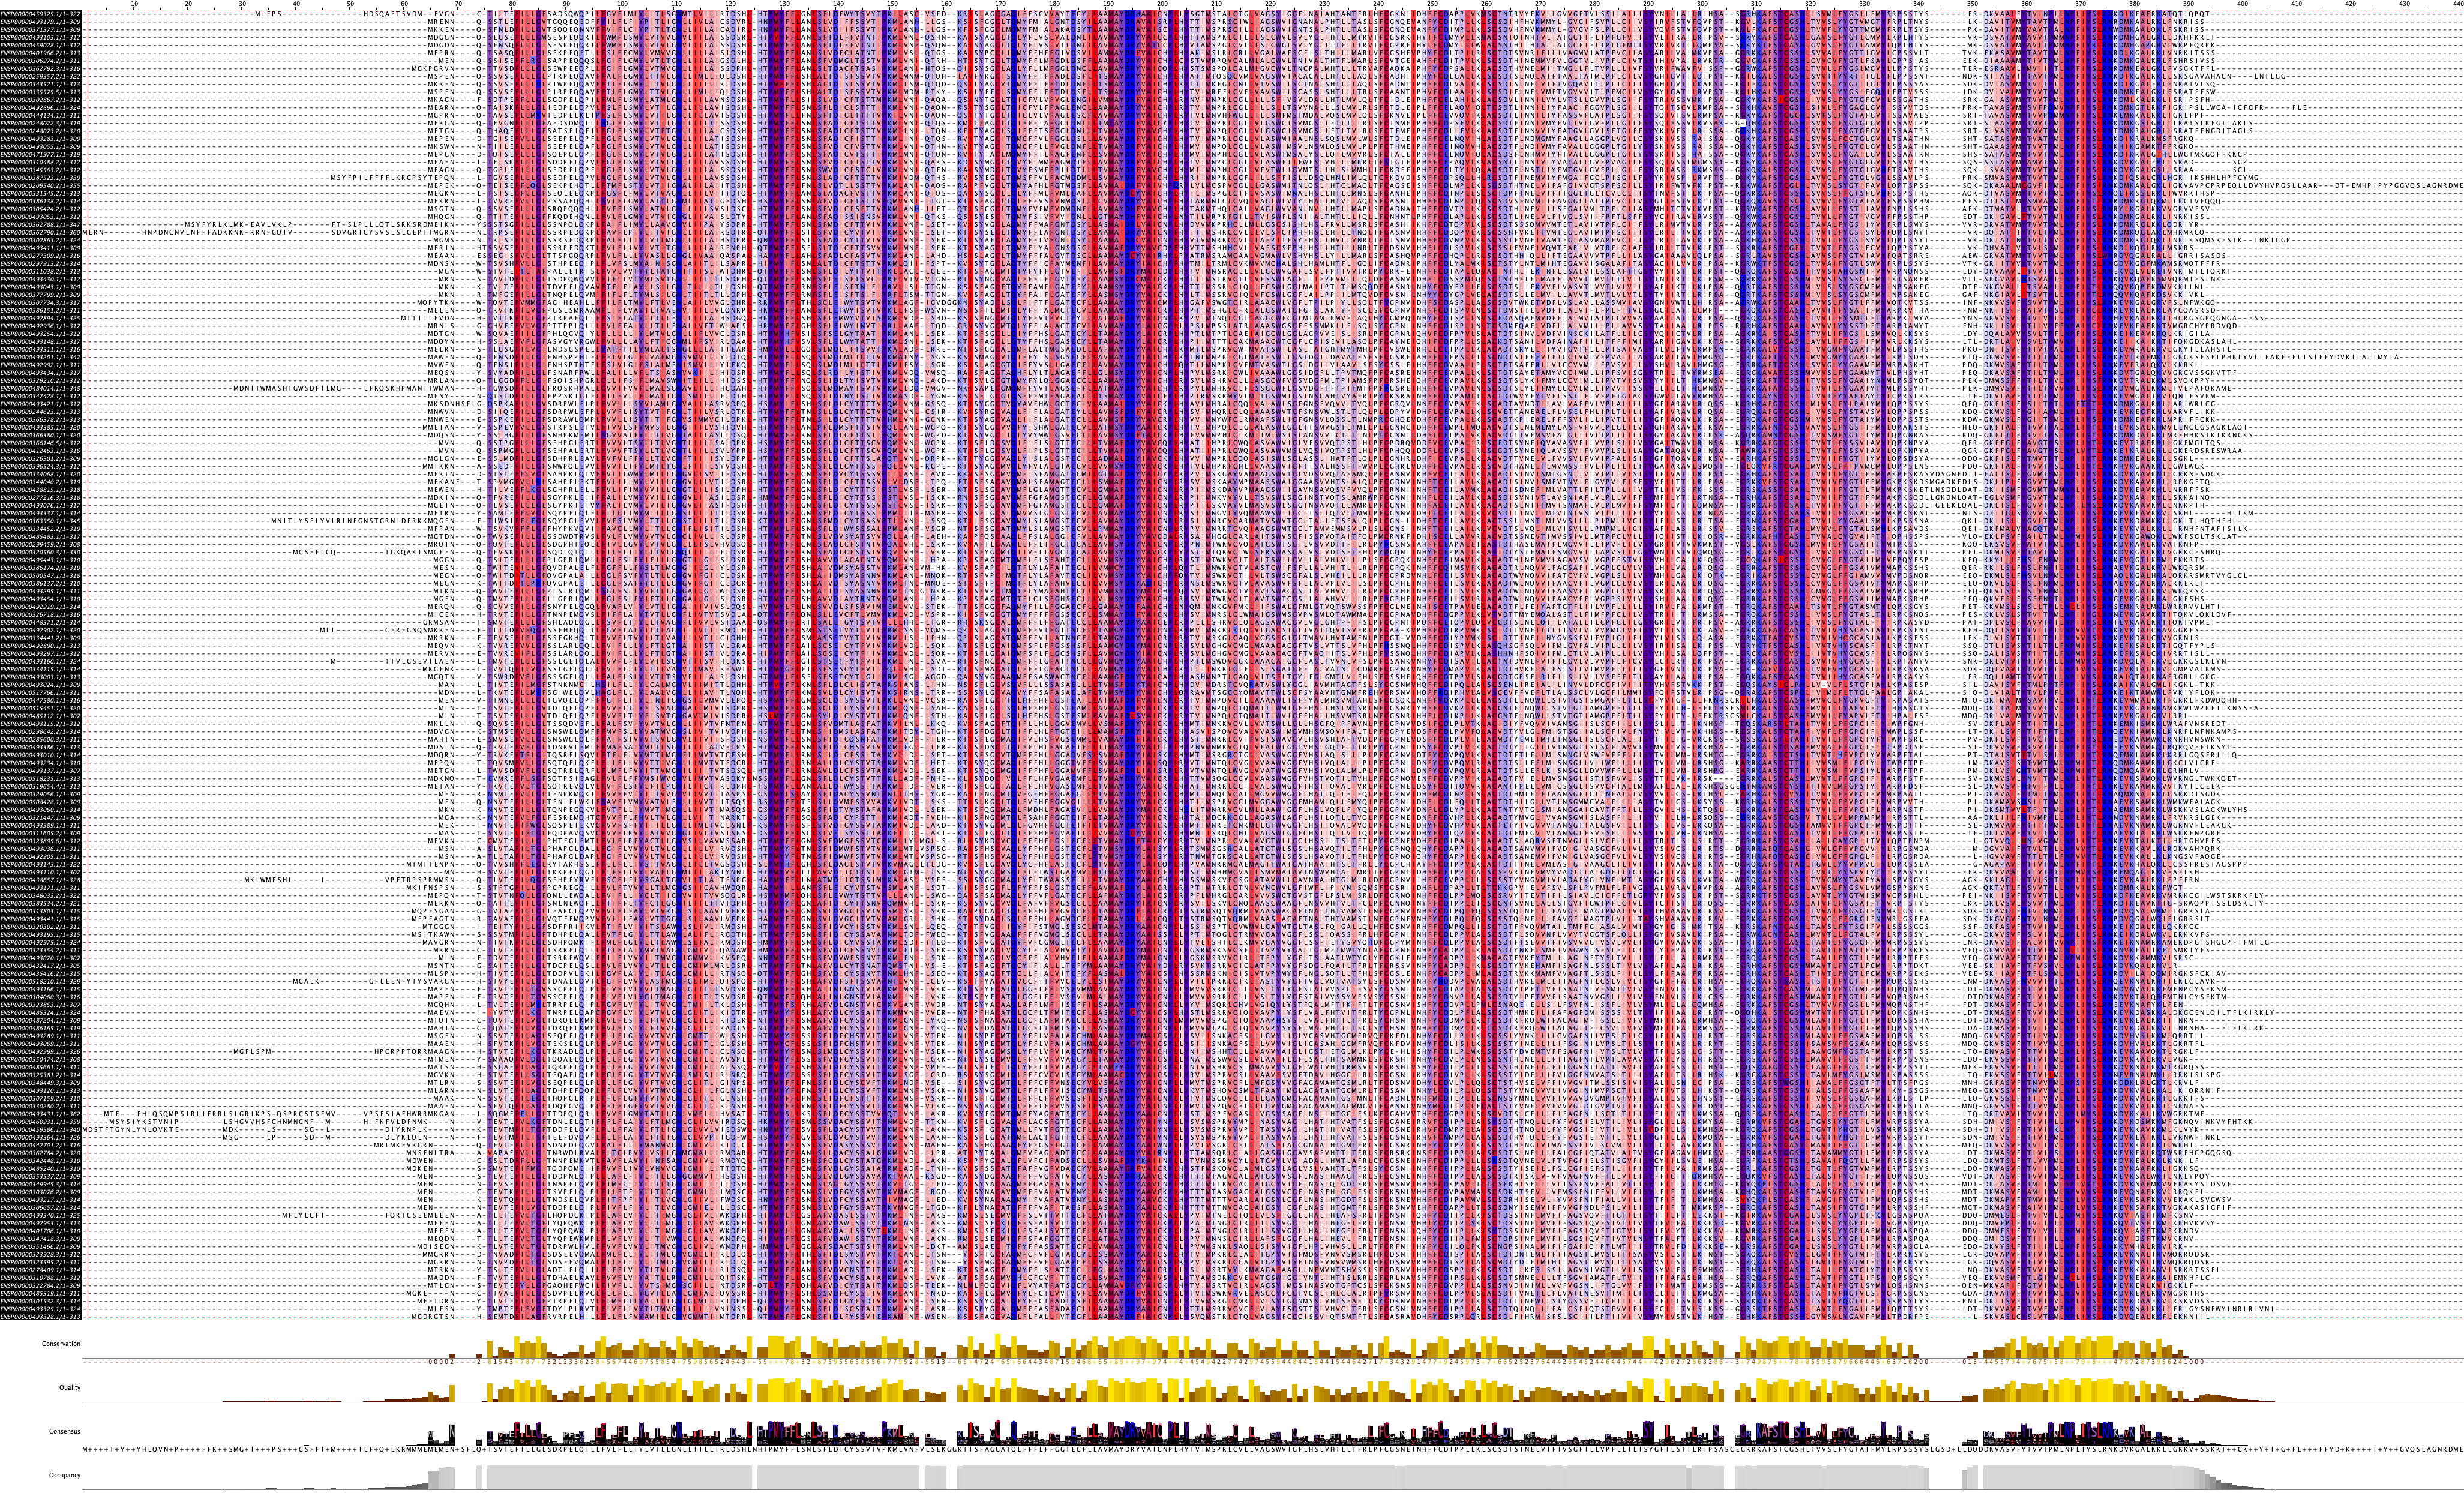

In [13]:
## ITOL 1- Created by taking the top 200 hits by score. It's interactive so have a browse!
IFrame(src="https://itol.embl.de/tree/1311115201475141744281105", width=1200, height=800)

In [14]:
# ITOL 2 - Created by using CD-HIT. It's interactive so have a browse!
IFrame(src="https://itol.embl.de/tree/1311115201339321744209585", width=1200, height=800)

## Sequence Analysis

InterPro is an excellent protein analysis tool which utilises a variety of models in order to identify conserved regions within a protein from its primary structure. These models include TMHMM and Phobius which both use hidden markov models in order to predict environment which that region of the protein is likely to localise in. Thus, in this case they are very useful in order to identify the location of the transmembrane helices present in our sequenced olfactory receptors. However, with so many different receptors it was difficult to pick which proteins to analyse with InterPro. My plan was to use my tree in order to guide my analysis into families of receptors, however I found that my CD-HIT clustered results made it difficult to find very distinct clusters of proteins. This is because it shows greater density of receptors than the tree with CD-HIT clustered results, which shows better biological diversity and meaning. This is not to say that I think the tree of the top 200 scoring proteins is a *better* tree but rather better for the task of directing my limited analysis. As a result, I redid alignment with the top 200 scoring proteins from the blastp search and built another tree using the nearest neighbour joining algorithm, which is Tree 1 presented above. I then used interpro to analyse clusters of those sequences. 

Due to the fact there are 200 proteins, it is beyond the scope of this project to analyse all of them and so 5 families' structure was analysed and compared with eachother to gain a grasp of the types of differences we may expect to see between families of olfactory proteins. Interpro was used throughout the analysis in order to compare and contrast transmembrane, cytosolic, and non-cytosolic regions. 

My analysis started off with the most distant clade: the 10A like olfactory receptors, coloured in light blue on ITOL 1. Analysis suggests that these sequences are united by two ligand binding pockets. There is a Zn²⁺ binding pocket (predicted by PIRSR) and another putative ligand binding pocket made up from different amino acids. Next to them lay the 2A (Orange) like olfactory receptors which seemed to have a very similar pattern of residues contributing to a ligand binding pocket but they were not predicted a Zn²⁺ binding pocket. Next along is the 2B and 2W (green and red respectively) families of receptors and one can notice a very similiar arrangement of transmembrane domains and residues associated with ligand binding in the structure but also a Zn²⁺ binding site. This could suggest that it is the Zn²⁺ binding pocket which differentiates the 2A family of receptors  from the 10A, 2B, and 2W families of receptor. At my level of analysis, it is difficult to differentiate between these four families using InterPro. This should be expected since, genes which are so closely related only tend to have very small structure differences. In the case of olfactory receptors, these minor amino acid differences tend to be in the binding pocket and thus affect the binding affinity of a receptor to a ligand. Without more indepth analysis of the function of the individual amino acids in the ligand binding pocket, it practically impossible to say how, or whether, these differences in amino acid sequence affect ligand binding. Thus, at my level of analysis it is, generally speaking, very difficult to identify meaningful differences between closely related families of olfactory receptor.

Throughout my analysis of these four families of olfactory receptor, I noticed the presence of 7 transmembrane domains in all receptors. This is typical of the family of G protein-coupled receptors (GPCRs), of which olfactory receptors are a part of. These transmembrane domains are highly conserved in GPCRs and their existence is evidenced in our sequence alignment by the strongly conserved bands of hydrophobic (red) amino acids.

In search for a more stark difference between families of proteins, I looked to the other side of the tree of receptors and found the 5V1 family of receptors (Purple). I compared the structure of this family of receptors to that 10A family of receptor and found that the 5V1 family tended to have a longer non-cytoplasmic domain  following the 4th transmembrane domain by 12 amino acids on average. This is a more substantial difference in the receptors' structure and may lead to a markedly different function of the protein when embedded in the plasma membrane. With this said, it is difficult to conclude anything concrete without more analysis of the receptors function in situ. See the below images for a direct comparison of the InterPro results of 5V1 (top) and 10A (bottom) family of receptor.
### 5V1 Family like Olfactory Receptor InterPro Results
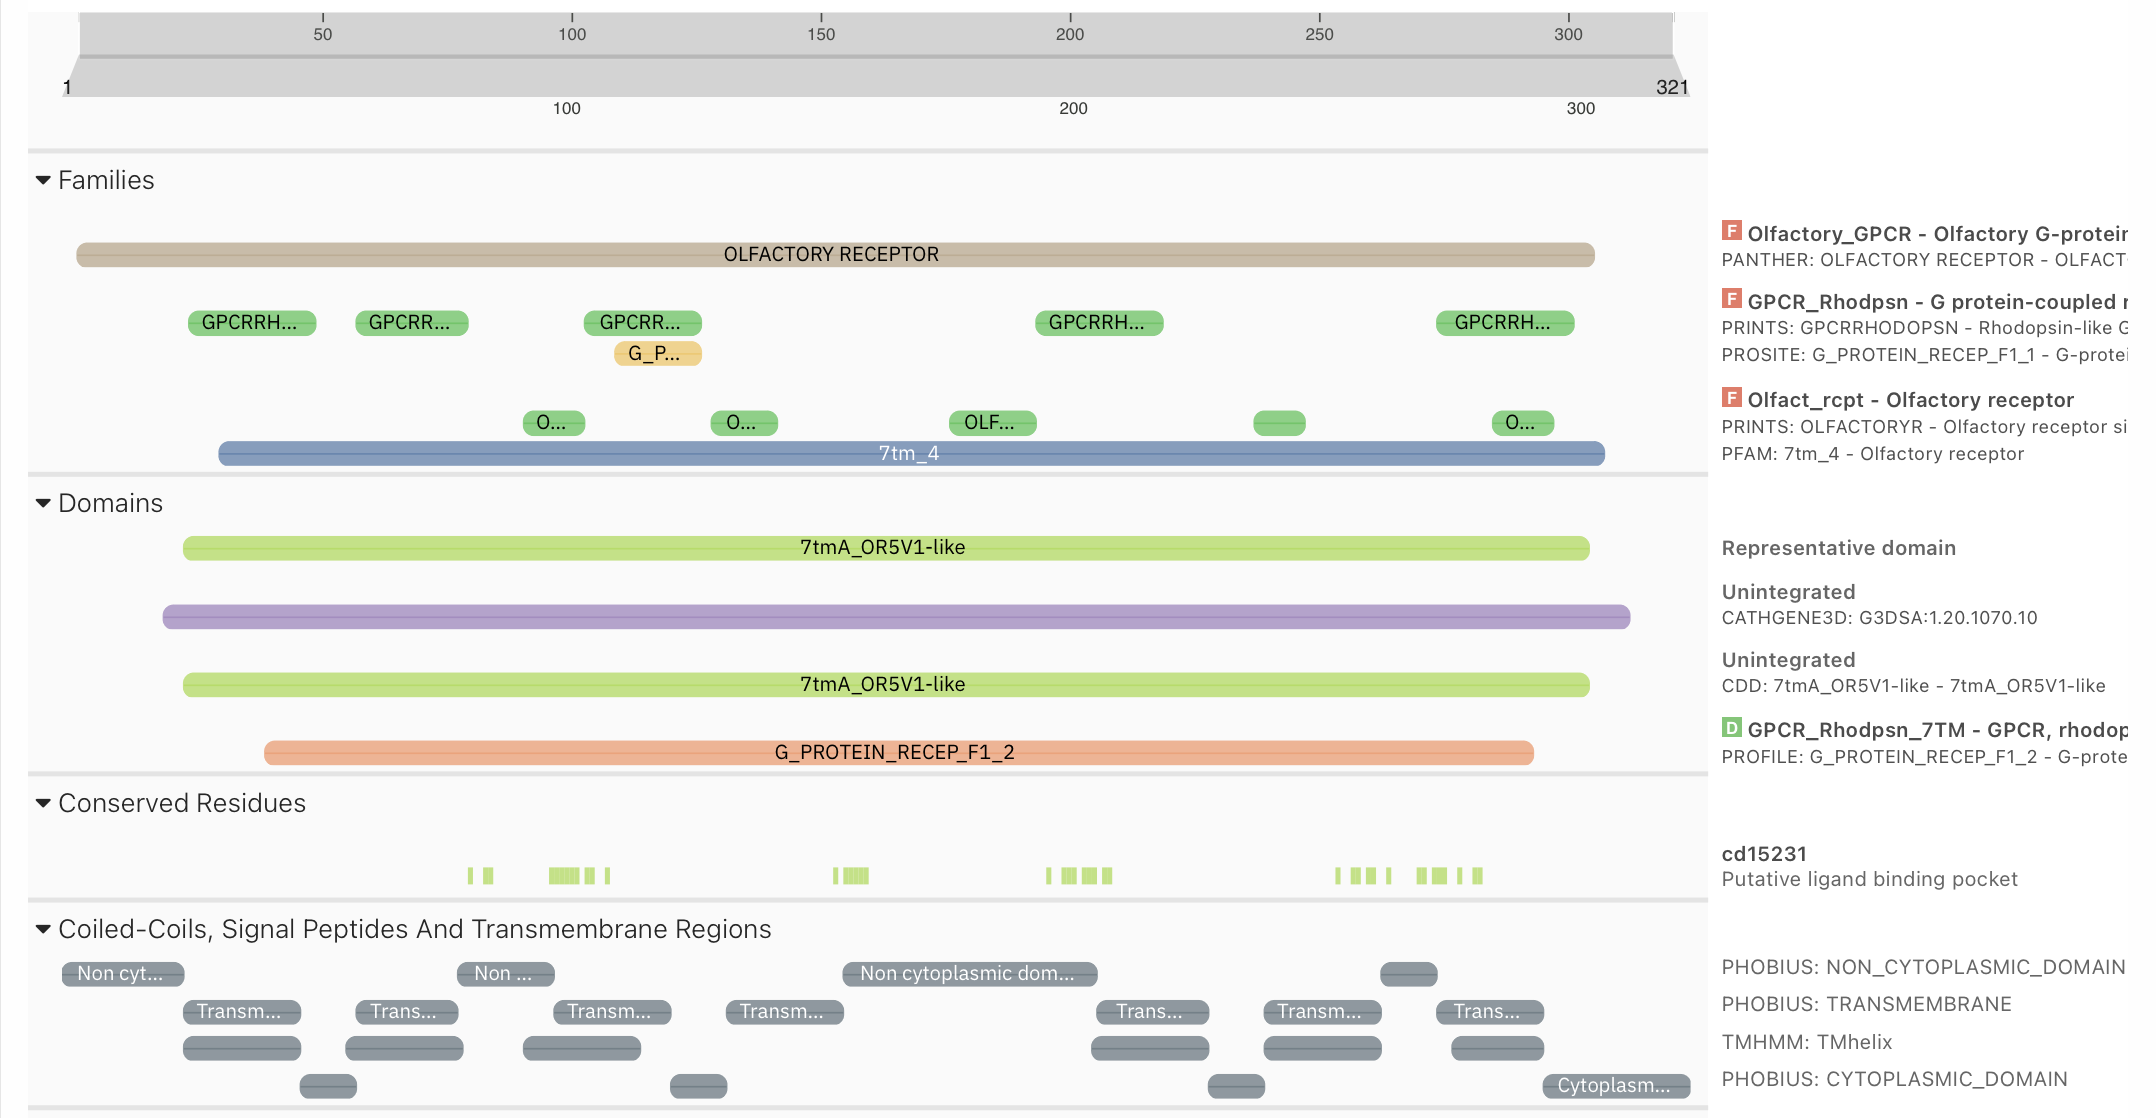
### 10A Family like Olfactory Receptor InterPro Results
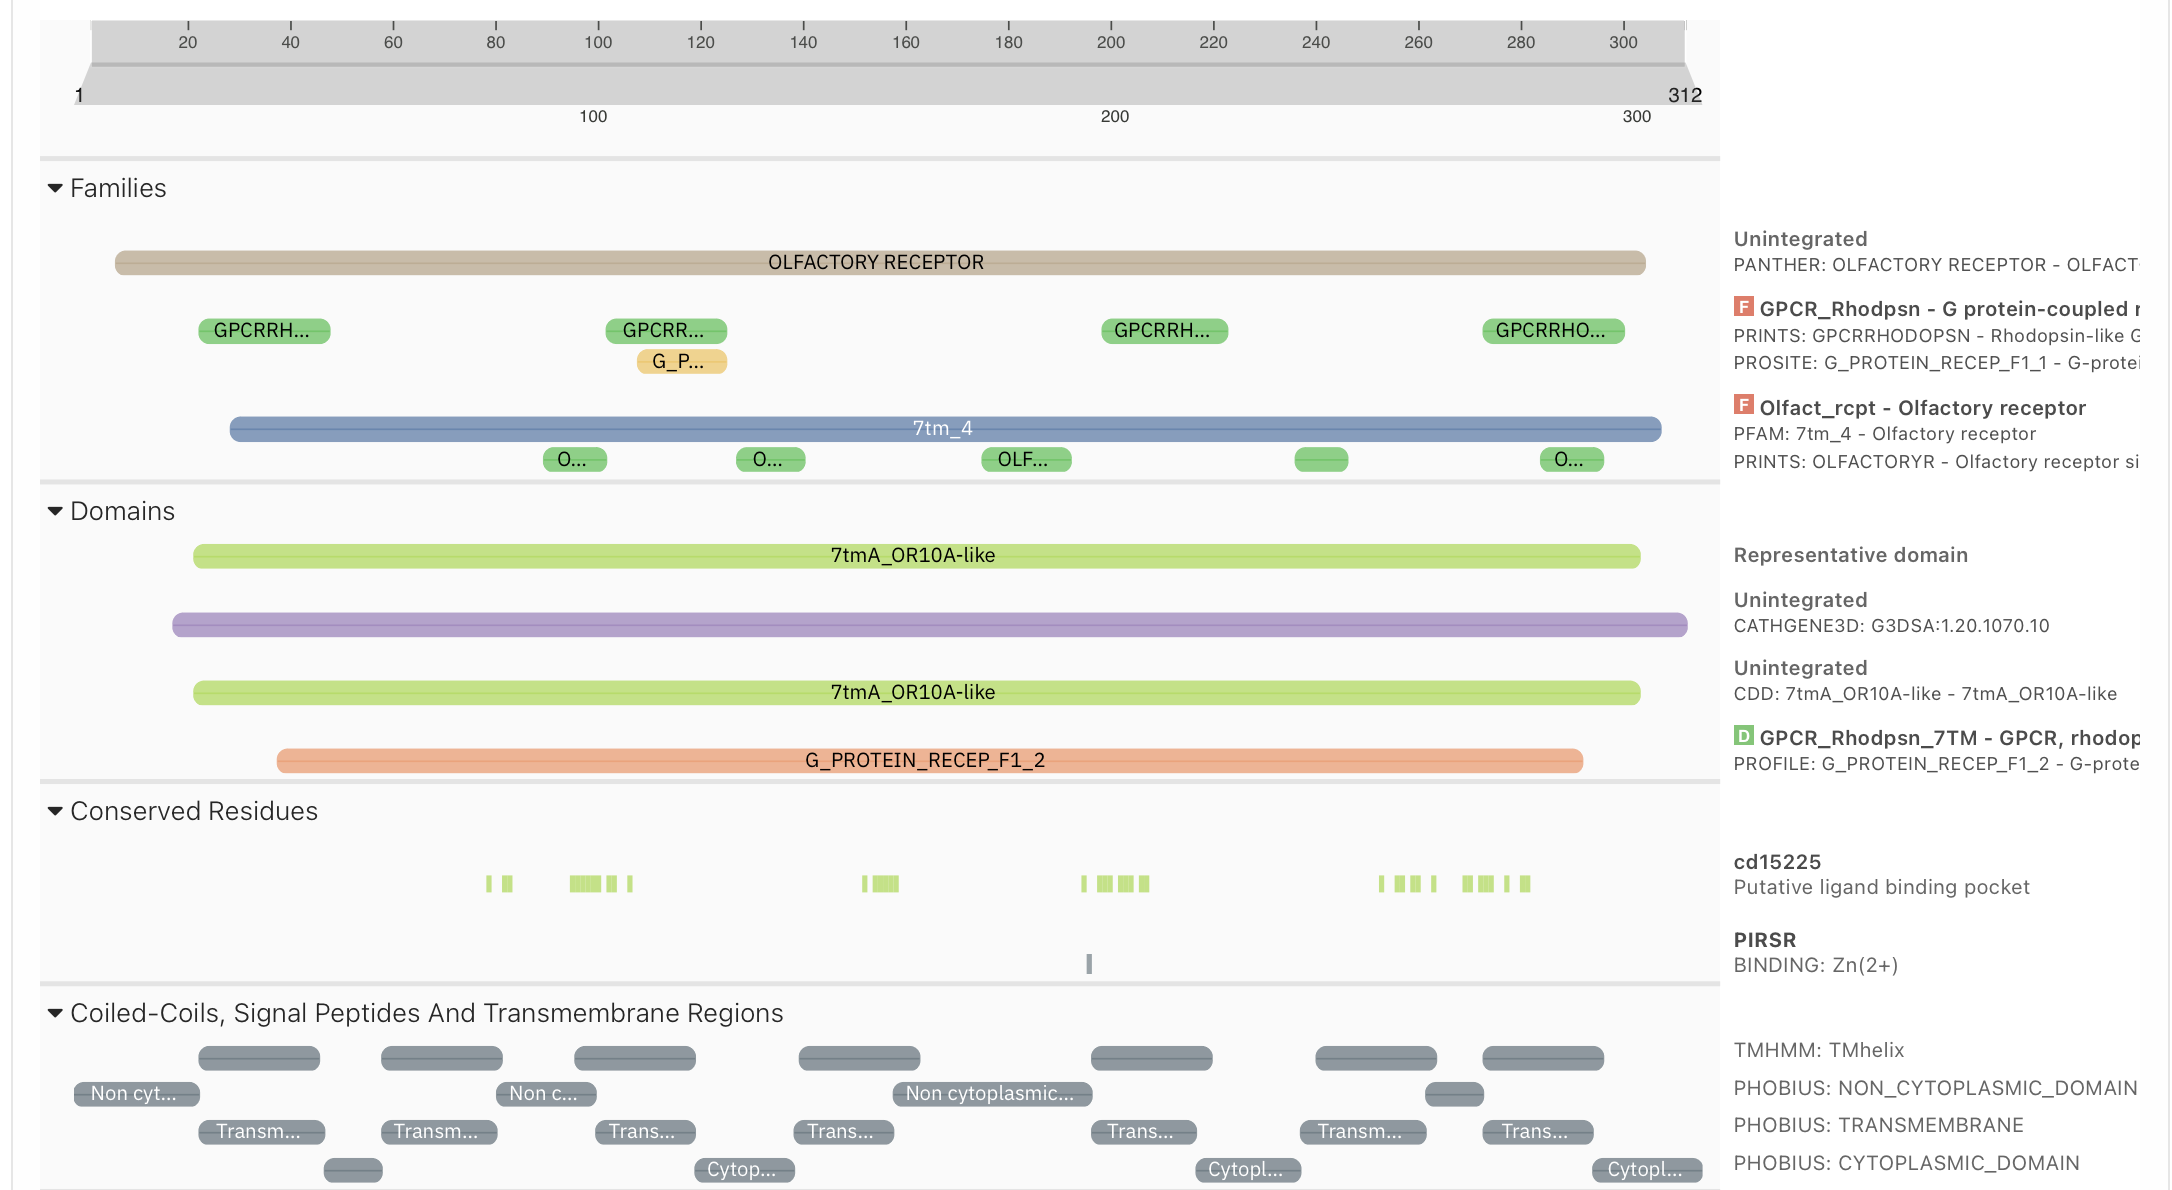

# Using HMMer and IQTree
A HMMer profile was built using sequences from my blastp hits which had been filtered through CD-HIT at a 95% threshold. The purpose of this was to stop overtraining of the model on the repetitive sequences that are present in the blastp data. The high threshold value means only very similar sequences are clustered and thus we do not lose diversity amongst our sequences. This can be thought of as cleaning the dataset so that the HMMer profile is trained on data which is more representative of the full range of olfactory receptors in the animal kingdom. This means that our HMMer profile should be more sensitive towards all types of olfactory receptor.

I used the search functionality to find possible olfactory proteins in different organisms. I chose to have a look at a large range of organisms (Gorillas, Mice, Bison, Chicken, Zebra Finches, Frogs, and Zebra Fish)  as I felt it would be interesting to see the spectrum of diversity possible in the animal kingdom. I chose: Gorillas since they are close relatives of humans; mice, chickens, zebra fish, and frogs since they all have well annotated genomes and are from across the animal kingdom. Finally, I chose Bison and Zebra Finches since Finches are two of my favourite animals! I filtered the hits from the HMMer search by picking only those with an E-value of below 1e-60. I chose thise number since my manual analysis of the dataset showed that there was a very low frequency of annotated pseudogenes in this range. By the end of this process I had roughly 4500 genes and so CD-HIT at a 70% threshold was used to filter the results. I chose a 70% threshold since I wanted to get results which were representative of families of olfactory receptors, rather than subfamilies, from the different organisms. This process should reduce clutter and redundancy on my tree and produce clear families whilst maintaining the biological diversity and signal from the input. The remaining 813 sequences were then aligned using a local version of CLUSTAL Omega and the tree below was produced by IQTree. I used IQTree in test mode in order to find the best fit substitution model. Part of my decision making in switching from the neighbour joining algorithm in JalView to IQ tree was that this allowed for better model selection, and ultimately, a more informative and accurate tree. 

My third and penultimate tree was very pleasing and shows clear areas of families of olfactory receptor as well as a great diversity of receptor. What is particularly glorious is how much more diversity there is in this tree compared to the ones preceding it. It was good to see that my more relaxed CD-HIT settings had led to a more obvious grouping of receptors into their families. I was optimistically hoping to see a class I and class II olfactory receptor divide but, due to the nature of my HMMer profile, the model did not do well at detecting class II olfactory receptors. This outcome should've been quite foreseable given the substantial differences between the two families. 

In [17]:
# Third ITOL - Created using IQTree.
IFrame(src="https://itol.embl.de/tree/1311115201269391744450441", width=1200, height=800)

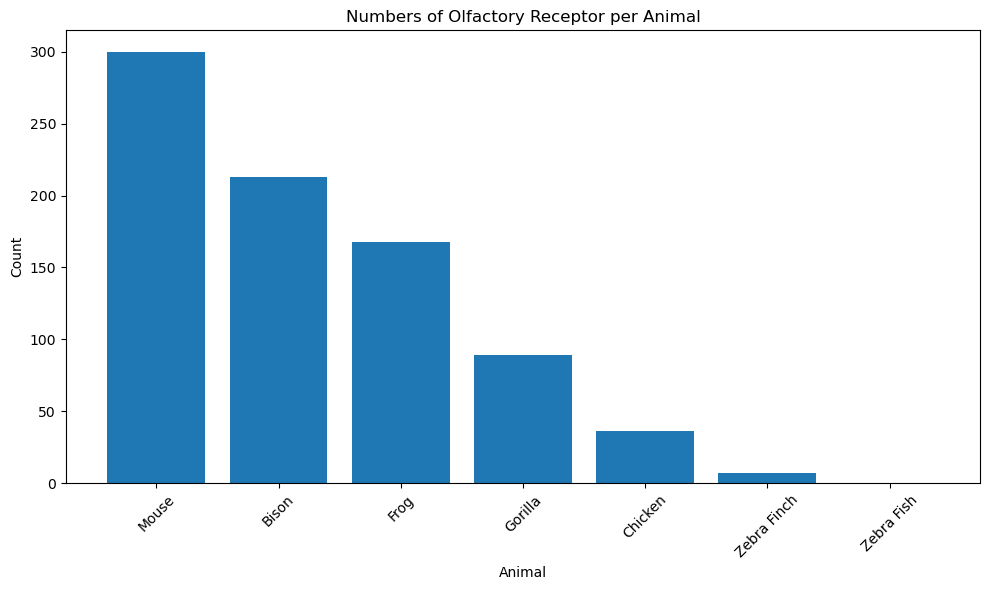

In [18]:
#Plotting Numbers 
# sorted data 
animals = ['Mouse', 'Bison', 'Frog', 'Gorilla', 'Chicken', 'Zebra Finch', 'Zebra Fish']
counts = [300, 213, 168, 89, 36, 7, 0]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(animals, counts)
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Numbers of Olfactory Receptor per Animal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This data demonstrates the diversity of olfactory receptors in different organisms and could provide a comparative way to quantify the strength of the sense of smell of different organisms. In our data, we can see that mice have by far the most olfactory receptors relative to the rest of the group and we can see that the birds demonstrate far fewer receptors than the mammals and amphibians. However, we must not take this data at face value. Our HMMer profile was only trained on human olfactory receptors and thus it is unlikely it will be able to accurately detect olfactory receptors throughout the kingdom of life. This is particularly the case when it is trying to detect receptors which are from distantly related organisms, such as chickens, zebra finches, and zebra fish. This means that the model will tend to be more accurate when the organism is more closely related to humans and thus we can trust the mammilian data more than we can trust the data from amphibians, fish, and birds. This claim can be further supported by the fact that literature estimates that Zebra Fish and Chickens have 150 [2] and 280-550 [3] olfactory receptor genes respectively. This demonstrates how the model has not been able to accurately to the Chicken olfactory receptors and is out by a factor of ~8-~15. It completely failed at detecting zebra fish olfactory receptors. This is likely because Zebra fish contain pre-dominantly class I receptors which are substantially different from the Class II receptors humans pre-dominantly have (Humans are estimated to have 57 Class I and 331 Class II receptors by [4]).

Contrastingly, data of the mouse genome suggests that mice have 1,200 olfactory receptor genes [5] and so our model is out by a factor of 4. Unfortunately, I could find no data on the number of receptors present in gorillas and bison to support this claim. The evidence I present from my data is anecdotal at best but does support the theory that grounds my suspicion that the model will be better on close relatives to humans.

Asides from the limitations of our HMMer profile, there are other limitations with our method. The use of CD-HIT in this way will not produce an accurate number of the olfactory receptors since it will be clustering sub-families, and even some families, of receptor together at a 70% threshold. This means that the number of unique receptors will be artificially decreased by our use of CD-HIT. This problem is exacerbated given the fact that all of the genes were combined together into the same  .txt file for the hmmsearch. This means that when CD-HIT is run on the output of the search, the genes from all of the different organisms will be *competing* against eachother during the clustering process (e.g. mice and dog genes can be clustered together leading to one of the orgnaisms losing a potentially valid receptor in the clustering process). This means that similar receptors from different organisms may be clustered together but only the longest of those will be released for subsequent sequence alignment (due to the way CD-HIT works). Thus only the longest gene of a cluster will be released counted in our subsequent analysis. Once again, this will further reduce number of olfactory receptors for each species. 


In order to generate a more accurate dataset for Dogs, Cats, Humans, and Mice I sought to rectify the limitations of the above implementation. I used the same profile in order to search for olfactory receptors in the Dog, Cat, and Mouse genomes. However, this time the searches were performed seperately, resulting in different output files. This meant that each set of hits from the search could be filtered based on E-values which were more appropriate for each organism. Mice, which have a broader diversity of olfactory receptors, were filtered out if their E-value was above 1e-20 whereas the dog and cat hits were both removed if they had a higher E-value than 1e-60. The values of these filteres were decided upon after manually analysing when annotated olfactory receptors started appearing abundantly in my hits. All of these filtered hits were then clustered using CD-HIT at a 99% similarity threshold. This process aimed to reduce the frequency of repeated genes in order to generate a more accurate estimate of the real number of olfactory receptors. This resulted in a total of 671 olfactory receptors genes for cats, 724 for dogs, and 1154 for mice (Visualised below). Finally, I filtered my human blastp hits at a 1e-30 threshold and used CD-HIT clustering at a 99% threshold to remove repeated sequences. This gave me a 216 human olfactory receptor genes. After some research, literature figures for the number of olfactory receptors genes were given as approximately 800 olfactory receptors for cats, 1,070 for dogs, 1,200 for mice, and 400 for humans [5]. Overall, I was happy with my data as they are not a far shot from the literature figures (see figure below for percentage differences of my project data to literature figures) .

 However, I believe that further refinement to the method is possible and recommended. I believe that this improvement would come from multiple distinct changes to the method. 
 
  Firstly, I believe that using an improved method to document the number of human olfactory receptor genes would allow for a better estimation of both human and other organisms' olfactory receptors. This is the case since we are training our HMMer profile off our dictionary of human olfactory receptors and thus it essential that it is as accurate as possible. Otherwise, this risks "rubbish in, rubbish out" of our model and will prohibit accurate detection of olfactory receptors in organisms which are not humans.
  
  These improvement could include, but are not limited to: 
  - Manually sorting through the full 463 blastp hits, rather than using CD-HIT or selecting the top 200, in order to more accurately select human olfactory receptor genes. 
  - Using more than one olfactory protein for our blastp search in the first place. Selecting a sample of olfactory receptors which were sequenced in the lab would allow blastp to better identify the full range of human olfactory receptors rather than those which are most similar to our singular sequenced receptor. 
  - Using PCR to confirm that these receptors are infact expressed in the nose.
  - Creating a HMMer profile using the olfactory receptors from a range of animals would enable the model to better detect olfactory receptors in organisms which are not humans. This would give a more wholesome picture of the diversity of olfactory receptors across the animal kingdom. Currently, only using the olfactory receptors from one animal risks excluding olfactory receptors which differ substantially from human receptors. This would have to be done in a way to not which does not overtrain the model. Done correctly, this would increase the effectiveness of the model. 

 Furthermore, I think that my use of CD-HIT could likely be refined. The clustering similarity thresholds that I used were not produced quantitatively and it is likely that they could have been refined to be refined in order to avoid removing authentic olfactory receptor genes. This removal of authentic receptors is likely part of the reason why all of my numbers are underestimations of their literature given values.

 Penultimately, I believe that I need a better system to remove pseudogenes from the HMMer or blastp search hits. Removing genes based upon an E-value threshold is a static and arbitrary way to try and remove pseudogenes from our results. Creating a HMMer profile of olfactory receptor pseudogenes manually may be an effective way to do this. This could allow for a more dynamic method to remove pseudo genes and reduce the number of authenthic olfactory receptor genes which are being filtered out and thus reduce the extent to which this project has underestimated the number of olfactory receptor genes.

Finally, our method counts the number of olfactory receptor *genes* but does not count the number of olfactory *receptors*. The task briefing asks to count the number of olfactory receptors and thus our method is flawed since we are assuming that all of our genes are expressed in situ. This is almost certainly an over generalisation as many genes can go unexpressed in the human genome due to factors such as epigenetic silencing. In order to generate a more accurate count and appreciation for the diversity of olfactory receptors in humans, mice, cats, and dogs we must use more wet lab techniques such as PCR in order to investigate which and how many of our uncovered genes are actually expressed in situ in the respective organism. 


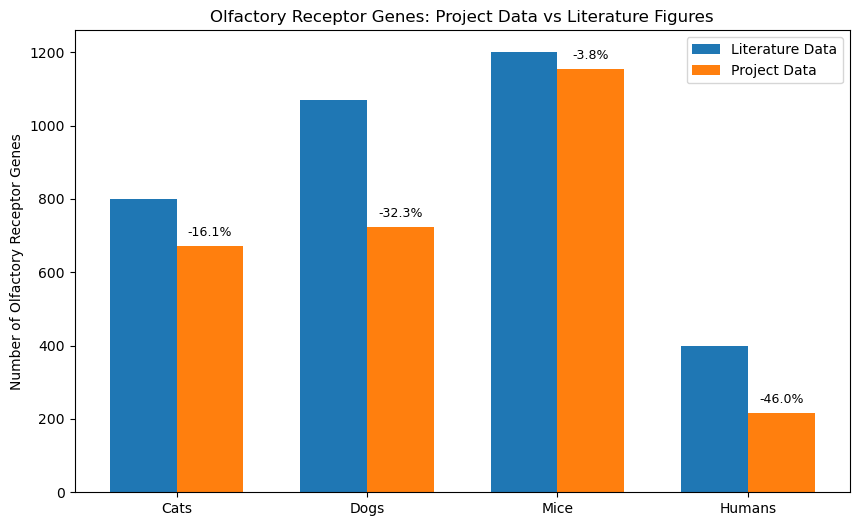

In [20]:
#Plotting Data
# Input Species and data
species = ["Cats", "Dogs", "Mice", "Humans"]
project_figures = np.array([671, 724, 1154, 216])
literature_figures = np.array([800, 1070, 1200, 400])  # Use np.nan for missing data

# Sort out X locations and bar widths
x = np.arange(len(species))
width = 0.35

# Calculate % differences
percent_diff = []
for p, l in zip(project_figures, literature_figures):
    diff = 100 * (p - l) / l
    percent_diff.append(f"{diff:+.1f}%")


#Making plots
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, literature_figures, width, label="Literature Data")
bars2 = ax.bar(x + width/2, project_figures, width, label="Project Data")

#Making % difference annotations on graph
for i, (bar, diff) in enumerate(zip(bars2, percent_diff)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 20, diff,
            ha="center", va="bottom", fontsize=9)

#Labels and format
ax.set_ylabel("Number of Olfactory Receptor Genes")
ax.set_title("Olfactory Receptor Genes: Project Data vs Literature Figures")
ax.set_xticks(x)
ax.set_xticklabels(species)
ax.legend()
plt.show()

# Command Line Prompts
These are the commands I used in terminal throughout my project, including an example command and an explanation of each.

```bash

BLAST Commands

makeblastdb -in human_peptides.fasta -dbtype prot -out human_peptide_db

	•	-in -> input path for human peptides
	•	-dbtype prot -> tells it to expect a protein database
	•	-out -> path for database creation

⸻

Run a BLASTP search

blastp -query olfactory_protein.fasta -db human_peptide_db -out results.txt -outfmt "7 qacc sacc qlen slen pident ppos length qstart qend sstart send evalue"
	•	-query -> query sequence input
	•	-db -> tells it which database to search
	•	-out -> tells it the desired output format

⸻

CD-HIT Commands

cd-hit -i mouse_hits_w_seqs.fasta o- CD-HIT-Clustered-Mouse-Hits -c 0.9

	•	-i -> input sequences path
	•	-o -> output sequences path
	•	-c -> cluster threshold

⸻

CLUSTAL Omega Local Commands

clustalo -i mouse_hits_w_seqs.fasta -o aligned_mouse_hits.fasta --force

	•	-i -> input sequences path
	•	-o -> output sequences path
	•	--force -> overwrites file in output path, this was useful since I often had to rerun alignments with manually editted sequences.

⸻

IQ Tree Commands

iqtree -s aligned_mouse_hits.fasta -m TEST -nt AUTO

	•	-s -> input file, which is the output of CLUSTAL Omega
	•	-m -> mode TEST, this means the IQTree tests the different tree building models and picks the one with the highest likelihood.
	•	-nt AUTO -> This is instructing IQ tree to automatically detect the number of CPU cores on my laptop and to use them all. This speeds up the process significantly.

⸻

HMMER Commands

Build HMM profile

hmmbuild olfactory.hmm olfactory_aligned.fasta

	•	olfactory_aligned.fasta -> the multiple sequence alignment
	•	olfactory.hmm -> the resulting profile HMM

⸻

Search sequences with HMM profile

hmmsearch --tblout olfactory_hits.tbl olfactory.hmm large_protein_db.fasta

	•	--tblout -> writes tabular output to olfactory_hits.tbl
	•	olfactory.hmm -> the input profile
	•	large_protein_db.fasta -> the FASTA file to search

⸻

Awk HMMER search results filtering

awk '$1 !~ /^#/ { if ($5 < 1e-30) print $1 }' olfactory_hits.tbl > filtered_ids.txt

	•	This command uses awk in order to filter out the results which have an E-Value less than 1e-30 and then outputs them to a .txt document. I then used the below code to match the sequence IDs in the txt file to its sequence.
```

In [23]:
def extacting_seqs_from_ids(fasta_path, id_file, output_fasta_path=None):
    """
    Taking the list of ids in a .txt file from HMMer and then matching them to a seq in the corresponding
    peptide database and then saves them to a fasta file. Function doesn't return anything itself.
    """
    # Reading stripping whitespace from non-blank lines then dropping any .1 or .version suffix
    requested = []
    with open(id_file) as f:
        for raw_text in f:
            stripped_text = raw_text.strip()
            if not stripped_text:
                continue
            core_id = stripped_text.split(".", 1)[0]
            requested.append(core_id)

    # Creating a set so that I can check if things exist really quickly - O(1)
    set_of_ids = set(requested)

    # Initializing vars for code below 
    results = {}
    current_header = None
    current_id = None
    seq_fragments = []

    # Iterating through each line of the FASTA file
    with open(fasta_path) as f:
        for line in f:
            #Stripping stuff from just the end of the line.
            line = line.rstrip()
            if line.startswith(">"):
                # Checking if its a sequence we want 
                if current_id in set_of_ids:
                    results[current_id] = (current_header, "".join(seq_fragments))
                # Recording the full line since its part of a header
                current_header = line
                # Picking out the sequence ID
                current_id = line[1:].split()[0].split("|")[0].split(".")[0]
                # Resetting sequences for new sequence to be recorded 
                seq_fragments = []
            else:
                # Appending sequence lines to build up the total sequence 
                seq_fragments.append(line)
        # After the loop, saving the full sequence if its id is in the set.
        if current_id in set_of_ids:
            results[current_id] = (current_header, "".join(seq_fragments))

    #Writing the sequence to an output in a fasta format
    with open(output_fasta_path, "w") as out:
        # Done to preserve the order of the sequences so that its the same as the input ids file as this makes troubleshooting easier
        for id in requested: 
            if id in results: 
                header_line, seq = results[id]
                out.write(f"{header_line}\n")
                # Splitting the sequence into 60-character lines per FASTA convention
                for i in range(0, len(seq), 60):
                    out.write(seq[i:i+60] + "\n")

    # Calculating how many requested IDs were found
    found = len(results)
    total = len(requested)
    # Printing a concise summary of the search results
    print(f"Found {found} out of {total} requested sequences.")


#Function Usage
# Path to my sequence database
fasta_file = "Part_3/HMM_stuff/Human_Cat_Dog_Alignment/Dog_Peptides.fa"
# Path to my all the ids which have been generated by hmmer as hits.
id_file = "Part_3/HMM_stuff/Human_Cat_Dog_Alignment/Dog_ids.txt"
# Path to outout file 
output_file = "Part_3/HMM_stuff/Human_Cat_Dog_Alignment/Dog_hits_w_seqs.fasta"
# Calling function
sequences = extacting_seqs_from_ids(fasta_file, id_file, output_file)


Found 735 out of 735 requested sequences.


# Bibliography
[1] ABC News - https://www.abc.net.au/news/2016-03-16/scientists-develop-chick-with-dinosaur-feet/7251736

[2] Alioto TS, Ngai J: The odorant receptor repertoire of teleost fish. BMC Genomics. 2005, 6: 173-

[3] International Chicken Genome Sequencing Consortium: Sequence and comparative analysis of the chicken genome provide unique perspectives on vertebrate evolution. Nature. 2004, 432 (7018): 695-716

[4] Niimura Y, Nei M: Evolution of olfactory receptor genes in the human genome. Proc Natl Acad Sci U S A. 2003, 100 (21): 12235–12240. doi:10.1073/pnas.1635157100

[5] Ache BW, Young JM: Olfaction: Diverse species, conserved principles. Neuron. 2005, 48 (3): 417–430